In [1]:
from transformers import AutoTokenizer, RobertaModel, AutoModel, RobertaTokenizer
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #bertforsequenceclassification
        self.bert = AutoModel.from_pretrained('Bert-base-uncased')
        self.fc = nn.Linear(768, 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x['pooler_output']
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [4]:
model = Model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained('Bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
# load the model and map_location to device
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP PROJECT/Models/mbti_bert.pth', map_location=device))

<All keys matched successfully>

In [8]:
def predict(model, tokenizer, df):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(df)):
            text = df.iloc[i]['line']
            encoding = tokenizer(
                text,
                return_tensors='pt',
                max_length=256,
                padding='max_length',
                truncation=True
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            outputs = torch.round(outputs)
            predictions.append(torch.tensor(outputs.cpu().numpy(), dtype = int))
        return predictions


def convert_binary_to_personality(binary):
    I = 'I' if (binary[0][0] == (1)) else 'E'
    N = 'N' if (binary[0][1] == (1)) else 'S'
    F = 'F' if (binary[0][2] == (1)) else 'T'
    J = 'J' if (binary[0][3] == (1)) else 'P'
    return I + N + F + J


## IRON MAN (2008)

In [9]:
df_ironman = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man.csv')
df_ironman.head()

,character,line,gender
0,TONY STARK,"Oh, I get it. You guys aren’t allowed to talk...",MALE
1,JIMMY,No. We’re allowed to talk.,MALE
2,TONY STARK,Oh. I see. So it’s personal.,MALE
3,RAMIREZ,I think they’re intimidated.,MALE
4,TONY STARK,"Good God, you’re a woman.",MALE


In [10]:
imp_chars = "PEPPER POTTS- PHIL COULSON- TONY STARK- OBADIAH- CHRISTINE EVERHART- JARVIS- JAMES RHODES- HAPPY HOGAN- HO YINSEN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
# print(len(important_characters))

['PEPPER POTTS', 'PHIL COULSON', 'TONY STARK', 'OBADIAH', 'CHRISTINE EVERHART', 'JARVIS', 'JAMES RHODES', 'HAPPY HOGAN', 'HO YINSEN']


In [11]:
df_ironman = df_ironman[df_ironman['character'].isin(important_characters)]
df_ironman.head()
print(df_ironman['character'].unique())

['TONY STARK' 'JAMES RHODES' 'OBADIAH' 'PEPPER POTTS' 'CHRISTINE EVERHART'
 'JARVIS' 'HO YINSEN' 'HAPPY HOGAN' 'PHIL COULSON']


In [12]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman = df_ironman.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman.head()

,character,gender,line
0,CHRISTINE EVERHART,FEMALE,"Christine Everhart, Vanity Fair Magazine. Can..."
1,HAPPY HOGAN,MALE,"Good to see you again, Sir. |||Wouldn’t dream ..."
2,HO YINSEN,MALE,I wouldn’t do that if I were you.|||What did I...
3,JAMES RHODES,MALE,"GET DOWN, TONY. GET THE --|||As Program Manag..."
4,JARVIS,MALE,"I’m sorry, Miss Everhart, you are not authoriz..."


In [13]:
df_ironman['label'] = predict(model, tokenizer, df_ironman)
# df_ironman.head()

df_ironman['personality'] = df_ironman['label'].apply(convert_binary_to_personality)
df_ironman.head()

,character,gender,line,label,personality
0,CHRISTINE EVERHART,FEMALE,"Christine Everhart, Vanity Fair Magazine. Can...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,HAPPY HOGAN,MALE,"Good to see you again, Sir. |||Wouldn’t dream ...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,HO YINSEN,MALE,I wouldn’t do that if I were you.|||What did I...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,JAMES RHODES,MALE,"GET DOWN, TONY. GET THE --|||As Program Manag...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,JARVIS,MALE,"I’m sorry, Miss Everhart, you are not authoriz...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [14]:
print(df_ironman[['character', 'personality']] )

            character personality
0  CHRISTINE EVERHART        INTP
1         HAPPY HOGAN        INFP
2           HO YINSEN        INTP
3        JAMES RHODES        INFP
4              JARVIS        INTJ
5             OBADIAH        ENFP
6        PEPPER POTTS        INTP
7        PHIL COULSON        ENTJ
8          TONY STARK        INTJ


## IRON MAN 2 (2010)

In [15]:
df_ironman2 = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man_2.csv')
df_ironman2.head()

,character,line,gender
0,TONY STARK,Been a while since I was up here in front of y...,MALE
1,CHRISTINE EVERHART,"Sorry, Mr Stark, do you honestly expect us to ...",FEMALE
2,TONY STARK,Yes,MALE
3,CHRISTINE EVERHART,And this mysterious bodyguard was somehow equi...,FEMALE
4,TONY STARK,I know that it’s confusing. It is one thing to...,MALE


In [16]:
imp_chars = "NICK FURY- NATASHA ROMANOFF- JUSTIN HAMMER- IVAN VANKO- HOWARD STARK- CHRISTINE EVERHART- JARVIS- JAMES RHODES- HAPPY HOGAN- PEPPER POTTS- TONY STARK- ANTON VANKO- STERN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['NICK FURY', 'NATASHA ROMANOFF', 'JUSTIN HAMMER', 'IVAN VANKO', 'HOWARD STARK', 'CHRISTINE EVERHART', 'JARVIS', 'JAMES RHODES', 'HAPPY HOGAN', 'PEPPER POTTS', 'TONY STARK', 'ANTON VANKO', 'STERN']
13


In [17]:
df_ironman2 = df_ironman2[df_ironman2['character'].isin(important_characters)]
df_ironman2.head()
print(df_ironman2['character'].unique())

['TONY STARK' 'CHRISTINE EVERHART' 'ANTON VANKO' 'IVAN VANKO'
 'HOWARD STARK' 'HAPPY HOGAN' 'STERN' 'JUSTIN HAMMER' 'JAMES RHODES'
 'JARVIS' 'PEPPER POTTS' 'NATASHA ROMANOFF' 'NICK FURY']


In [18]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman2 = df_ironman2.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman2.head()

,character,gender,line
0,ANTON VANKO,MALE,Ivan. Vanya. That should be you.|||I’m sorry. ...
1,CHRISTINE EVERHART,FEMALE,"Sorry, Mr Stark, do you honestly expect us to ..."
2,HAPPY HOGAN,MALE,"Make sure you join me…|||Open up, let’s go.|||..."
3,HOWARD STARK,MALE,Everything is achievable through technology. B...
4,IVAN VANKO,MALE,Don’t listen to that crap|||You… You lose. You...


In [19]:
df_ironman2['label'] = predict(model, tokenizer, df_ironman2)
# df_ironman.head()

df_ironman2['personality'] = df_ironman2['label'].apply(convert_binary_to_personality)
df_ironman2.head()

,character,gender,line,label,personality
0,ANTON VANKO,MALE,Ivan. Vanya. That should be you.|||I’m sorry. ...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
1,CHRISTINE EVERHART,FEMALE,"Sorry, Mr Stark, do you honestly expect us to ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,HAPPY HOGAN,MALE,"Make sure you join me…|||Open up, let’s go.|||...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,HOWARD STARK,MALE,Everything is achievable through technology. B...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,IVAN VANKO,MALE,Don’t listen to that crap|||You… You lose. You...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [20]:
print(df_ironman[['character', 'personality']] )

            character personality
0  CHRISTINE EVERHART        INTP
1         HAPPY HOGAN        INFP
2           HO YINSEN        INTP
3        JAMES RHODES        INFP
4              JARVIS        INTJ
5             OBADIAH        ENFP
6        PEPPER POTTS        INTP
7        PHIL COULSON        ENTJ
8          TONY STARK        INTJ


## THOR (2011)

In [21]:
df_thor = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/thor.csv')
df_thor.head()

,character,line,gender
0,JANE,Hurry!,FEMALE
1,JANE,Oh-- watch your head.,FEMALE
2,SELVIG,"Thanks. So what's this ""anomaly"" of yours supp...",FEMALE
3,JANE,It's a little different each time. Once it loo...,FEMALE
4,SELVIG,"Racing Àúround Orion?"" I've always said you sh...",FEMALE


In [22]:
imp_chars = "PHIL COULSON- HEIMDALL- SIF- SELVIG- CLINT BARTON- THOR- ISABELA- ODIN- LOKI- HOGUN- JANE"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['PHIL COULSON', 'HEIMDALL', 'SIF', 'SELVIG', 'CLINT BARTON', 'THOR', 'ISABELA', 'ODIN', 'LOKI', 'HOGUN', 'JANE']
11


In [23]:
df_thor = df_thor[df_thor['character'].isin(important_characters)]
df_thor.head()
print(df_thor['character'].unique())

['JANE' 'SELVIG' 'HEIMDALL' 'ODIN' 'THOR' 'LOKI' 'SIF' 'HOGUN'
 'PHIL COULSON' 'ISABELA' 'CLINT BARTON']


In [24]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_thor = df_thor.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_thor.head()

,character,gender,line
0,CLINT BARTON,MALE,"One shot, one kill, sir. Just give the word.||..."
1,HEIMDALL,MALE,"Questions, they've always asked questions -- t..."
2,HOGUN,MALE,I told you they'd cancel it.|||And I. The Warr...
3,ISABELA,FEMALE,Did you see that? The first time she brings a ...
4,JANE,FEMALE,Hurry!|||Oh-- watch your head.|||It's a little...


In [25]:
df_thor['label'] = predict(model, tokenizer, df_thor)
# df_ironman.head()

df_thor['personality'] = df_thor['label'].apply(convert_binary_to_personality)
df_thor.head()

,character,gender,line,label,personality
0,CLINT BARTON,MALE,"One shot, one kill, sir. Just give the word.||...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
1,HEIMDALL,MALE,"Questions, they've always asked questions -- t...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
2,HOGUN,MALE,I told you they'd cancel it.|||And I. The Warr...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
3,ISABELA,FEMALE,Did you see that? The first time she brings a ...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,JANE,FEMALE,Hurry!|||Oh-- watch your head.|||It's a little...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [26]:
print(df_thor[['character', 'personality']] )

       character personality
0   CLINT BARTON        INFJ
1       HEIMDALL        INFJ
2          HOGUN        INTJ
3        ISABELA        INFP
4           JANE        INFP
5           LOKI        INFJ
6           ODIN        INFJ
7   PHIL COULSON        INTJ
8         SELVIG        INFJ
9            SIF        INFJ
10          THOR        INFP


## CAPTAIN AMERICA: THE FIRST AVENGER (2011)

In [27]:
df_ca = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/captain_america.csv')
df_ca.head()

,character,line,gender
0,SEARCH TEAM LEADER,Are you the guys from Washington?,MALE
1,SHIELD TECH,You get many other visitors out here?,MALE
2,SHIELD LIEUTENANT,How long have you been on site?,MALE
3,SEARCH TEAM LEADER,Since this morning. A Russian oil team called ...,MALE
4,SHIELD LIEUTENANT,How come nobody spotted it before?,MALE


In [28]:
imp_chars = "STEVE ROGERS- PEGGY CARTER- NICK FURY- SENATOR BRANDT- HOWARD STARK- JIM MORITA- GILMORE HODGE- HEINZ KRUGER- RED SKULL- DR. ARNIM ZOLA"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'PEGGY CARTER', 'NICK FURY', 'SENATOR BRANDT', 'HOWARD STARK', 'JIM MORITA', 'GILMORE HODGE', 'HEINZ KRUGER', 'RED SKULL', 'DR. ARNIM ZOLA']
10


In [29]:
df_ca = df_ca[df_ca['character'].isin(important_characters)]
df_ca.head()
print(df_ca['character'].unique())

['RED SKULL' 'STEVE ROGERS' 'HOWARD STARK' 'DR. ARNIM ZOLA' 'PEGGY CARTER'
 'GILMORE HODGE' 'SENATOR BRANDT' 'HEINZ KRUGER' 'JIM MORITA' 'NICK FURY']


In [30]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ca = df_ca.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ca.head()

,character,gender,line
0,DR. ARNIM ZOLA,MALE,My machine requires the most delicate calibrat...
1,GILMORE HODGE,MALE,"What’s with the accent, Queen Victoria? Though..."
2,HEINZ KRUGER,MALE,"Fred Clemson, State Department. If this proje..."
3,HOWARD STARK,MALE,"Ladies and gentlemen, what if I told you that ..."
4,JIM MORITA,MALE,"I’m from Fresno, Ace.|||You know how to use th..."


In [31]:
df_ca['label'] = predict(model, tokenizer, df_ca)
# df_ironman.head()

df_ca['personality'] = df_ca['label'].apply(convert_binary_to_personality)
df_ca.head()

,character,gender,line,label,personality
0,DR. ARNIM ZOLA,MALE,My machine requires the most delicate calibrat...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
1,GILMORE HODGE,MALE,"What’s with the accent, Queen Victoria? Though...","[[tensor(0), tensor(1), tensor(1), tensor(1)]]",ENFJ
2,HEINZ KRUGER,MALE,"Fred Clemson, State Department. If this proje...","[[tensor(0), tensor(1), tensor(1), tensor(0)]]",ENFP
3,HOWARD STARK,MALE,"Ladies and gentlemen, what if I told you that ...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,JIM MORITA,MALE,"I’m from Fresno, Ace.|||You know how to use th...","[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP


In [32]:
print(df_ca[['character', 'personality']] )

        character personality
0  DR. ARNIM ZOLA        INTJ
1   GILMORE HODGE        ENFJ
2    HEINZ KRUGER        ENFP
3    HOWARD STARK        INTP
4      JIM MORITA        ENTP
5       NICK FURY        INFJ
6    PEGGY CARTER        INTJ
7       RED SKULL        INTJ
8  SENATOR BRANDT        INFJ
9    STEVE ROGERS        INTP


## THE AVENGERS (2012)

In [33]:
df_avengers = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/avengers.csv')
df_avengers.head()

,character,line,gender
0,THE OTHER,The Tesseract has awakened. It is on a little ...,MALE
1,THE OTHER,But our ally knows its workings as they never ...,MALE
2,THE OTHER,"...our Chitauri, will follow. The world will b...",MALE
3,INTERCOM VOICE,"All personnel, evacuation order has been confi...",MALE
4,INTERCOM VOICE,...for all campus evacuation.,MALE


In [34]:
imp_chars = "STEVE ROGERS- NICK FURY- PEPPER POTTS- PHIL COULSON- STAN LEE- TONY STARK- GEORGI LUCHKOV- SELVIG- PEGGY CARTER- JARVIS- CLINT BARTON- THOR- NATASHA ROMANOFF- AGENT JASPER SITWELL- BRUCE BANNER- LOKI- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'PEPPER POTTS', 'PHIL COULSON', 'STAN LEE', 'TONY STARK', 'GEORGI LUCHKOV', 'SELVIG', 'PEGGY CARTER', 'JARVIS', 'CLINT BARTON', 'THOR', 'NATASHA ROMANOFF', 'AGENT JASPER SITWELL', 'BRUCE BANNER', 'LOKI', 'MARIA HILL']
17


In [35]:
df_avengers = df_avengers[df_avengers['character'].isin(important_characters)]
df_avengers.head()
print(df_avengers['character'].unique())

['NICK FURY' 'PHIL COULSON' 'MARIA HILL' 'SELVIG' 'CLINT BARTON' 'LOKI'
 'GEORGI LUCHKOV' 'NATASHA ROMANOFF' 'BRUCE BANNER' 'STEVE ROGERS'
 'PEGGY CARTER' 'TONY STARK' 'PEPPER POTTS' 'JARVIS'
 'AGENT JASPER SITWELL' 'THOR' 'STAN LEE']


In [36]:
# conavengerstenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_avengers = df_avengers.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_avengers.head()

,character,gender,line
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...
3,GEORGI LUCHKOV,FEMALE,This isn’t how I wanted this evening to go.|||...
4,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |..."


In [37]:
df_avengers['label'] = predict(model, tokenizer, df_avengers)
# df_ironman.head()

df_avengers['personality'] = df_avengers['label'].apply(convert_binary_to_personality)
df_avengers.head()

,character,gender,line,label,personality
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...,"[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...,"[[tensor(0), tensor(1), tensor(0), tensor(1)]]",ENTJ
3,GEORGI LUCHKOV,FEMALE,This isn’t how I wanted this evening to go.|||...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [38]:


print(df_avengers[['character', 'personality']] )

               character personality
0   AGENT JASPER SITWELL        INFP
1           BRUCE BANNER        ENTP
2           CLINT BARTON        ENTJ
3         GEORGI LUCHKOV        INTP
4                 JARVIS        INTJ
5                   LOKI        INFP
6             MARIA HILL        INTJ
7       NATASHA ROMANOFF        INTP
8              NICK FURY        INTJ
9           PEGGY CARTER        ENFP
10          PEPPER POTTS        INTP
11          PHIL COULSON        INTJ
12                SELVIG        INFP
13              STAN LEE        ENFP
14          STEVE ROGERS        INTP
15                  THOR        INFP
16            TONY STARK        ENTP


## IRON MAN 3 (2013)

In [39]:
df_ironman3 = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man_3.csv')
df_ironman3.head()

,character,line,gender
0,TONY STARK,We create our own demons. Who said that? What ...,MALE
1,TONY STARK,I'm gonna start again. Let's track this from t...,MALE
2,HAPPY HOGAN,Half hour till the ball drops.,MALE
3,TONY STARK,"Hey, do you want...?",MALE
4,PARTY GUEST,"Tony Stark? Great speech, man!",NEUTRAL


In [40]:
imp_chars = "PEPPER POTTS- SAVIN- TONY STARK- TREVOR SLATTERY- JARVIS- HAPPY HOGAN- HEATHER- MAYA HANSEN- ALDRICH KILLIAN- JOAN RIVERS- JAMES RHODES- BRUCE BANNER- HO YINSEN- HARLEY KEENER"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['PEPPER POTTS', 'SAVIN', 'TONY STARK', 'TREVOR SLATTERY', 'JARVIS', 'HAPPY HOGAN', 'HEATHER', 'MAYA HANSEN', 'ALDRICH KILLIAN', 'JOAN RIVERS', 'JAMES RHODES', 'BRUCE BANNER', 'HO YINSEN', 'HARLEY KEENER']
14


In [41]:
df_ironman3 = df_ironman3[df_ironman3['character'].isin(important_characters)]
df_ironman3.head()
print(df_ironman3['character'].unique())

['TONY STARK' 'HAPPY HOGAN' 'MAYA HANSEN' 'HO YINSEN' 'ALDRICH KILLIAN'
 'JARVIS' 'JOAN RIVERS' 'JAMES RHODES' 'PEPPER POTTS' 'SAVIN'
 'HARLEY KEENER' 'TREVOR SLATTERY' 'HEATHER' 'BRUCE BANNER']


In [42]:
# conironman3tenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman3 = df_ironman3.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman3.head()

,character,gender,line
0,ALDRICH KILLIAN,MALE,"Mr. Stark!|||Oh, wow! Hey, Tony! Aldrich Killi..."
1,BRUCE BANNER,MALE,"Sorry... I was, yeah. We were at, uh...|||I wa..."
2,HAPPY HOGAN,MALE,"Half hour till the ball drops.|||I got you, pa..."
3,HARLEY KEENER,FEMALE,Freeze! Don't move.|||What's that thing on you...
4,HEATHER,FEMALE,"Oh, God! No! No!|||What? Oh!"


In [43]:
df_ironman3['label'] = predict(model, tokenizer, df_ironman3)
# df_ironman.head()

df_ironman3['personality'] = df_ironman3['label'].apply(convert_binary_to_personality)
df_ironman3.head()

,character,gender,line,label,personality
0,ALDRICH KILLIAN,MALE,"Mr. Stark!|||Oh, wow! Hey, Tony! Aldrich Killi...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,BRUCE BANNER,MALE,"Sorry... I was, yeah. We were at, uh...|||I wa...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,HAPPY HOGAN,MALE,"Half hour till the ball drops.|||I got you, pa...","[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP
3,HARLEY KEENER,FEMALE,Freeze! Don't move.|||What's that thing on you...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,HEATHER,FEMALE,"Oh, God! No! No!|||What? Oh!","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [44]:
print(df_ironman3[['character', 'personality']] )

          character personality
0   ALDRICH KILLIAN        INTP
1      BRUCE BANNER        INFP
2       HAPPY HOGAN        ENTP
3     HARLEY KEENER        INTP
4           HEATHER        INFP
5         HO YINSEN        INTJ
6      JAMES RHODES        ENTP
7            JARVIS        INTJ
8       JOAN RIVERS        INTP
9       MAYA HANSEN        INTP
10     PEPPER POTTS        INTJ
11            SAVIN        ENTJ
12       TONY STARK        INTP
13  TREVOR SLATTERY        INTP


## THOR: THE DARK WORLD (2013)

In [45]:
df_thordw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/thor_dark_world.csv')
df_thordw.head()

,character,line,gender
0,ODIN,Long before the birth of light there was darkn...,MALE
1,ODIN,Such evil was possible through the power of th...,MALE
2,ODIN,"The noble armies of Asgard, led by my father, ...",MALE
3,KURSE,Malekith! Asgard's forces are upon us.,MALE
4,MALEKITH,Send the Kursed.,MALE


In [46]:
imp_chars = "KURSE- HEIMDALL- SIF- SELVIG- THOR- IAN BOOTHBY- ODIN- HOGUN- JANE- LOKI"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['KURSE', 'HEIMDALL', 'SIF', 'SELVIG', 'THOR', 'IAN BOOTHBY', 'ODIN', 'HOGUN', 'JANE', 'LOKI']
10


In [47]:
df_thordw = df_thordw[df_thordw['character'].isin(important_characters)]
df_thordw.head()
print(df_thordw['character'].unique())

['ODIN' 'KURSE' 'LOKI' 'SIF' 'THOR' 'HOGUN' 'JANE' 'IAN BOOTHBY'
 'HEIMDALL' 'SELVIG']


In [48]:
# conthordwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_thordw = df_thordw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_thordw.head()

,character,gender,line
0,HEIMDALL,MALE,You're late.|||Then you're doing one of them i...
1,HOGUN,MALE,Where do we go next?|||You have my thanks.
2,IAN BOOTHBY,MALE,"Hello, Dr. Foster. It's uh...it's a great hono..."
3,JANE,FEMALE,"Hi.|||Why does there have to be a story, there..."
4,KURSE,MALE,Malekith! Asgard's forces are upon us.|||Our s...


In [49]:
df_thordw['label'] = predict(model, tokenizer, df_thordw)

df_thordw['personality'] = df_thordw['label'].apply(convert_binary_to_personality)
df_thordw.head()

,character,gender,line,label,personality
0,HEIMDALL,MALE,You're late.|||Then you're doing one of them i...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
1,HOGUN,MALE,Where do we go next?|||You have my thanks.,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,IAN BOOTHBY,MALE,"Hello, Dr. Foster. It's uh...it's a great hono...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
3,JANE,FEMALE,"Hi.|||Why does there have to be a story, there...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,KURSE,MALE,Malekith! Asgard's forces are upon us.|||Our s...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [50]:
print(df_thordw[['character', 'personality']] )

     character personality
0     HEIMDALL        INTJ
1        HOGUN        INFP
2  IAN BOOTHBY        INFJ
3         JANE        INFP
4        KURSE        INTJ
5         LOKI        INTJ
6         ODIN        INTJ
7       SELVIG        INFP
8          SIF        INFJ
9         THOR        INFJ


## CAPTAIN AMERICA: THE WINTER SOLDIER (2014)

In [51]:
df_caws = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/winter_soldier.csv')
df_caws.head()

,character,line,gender
0,STEVE ROGERS,On your left.,MALE
1,STEVE ROGERS,On your left.,MALE
2,SAM WILSON,"Uh-huh, on my left. Got it.",MALE
3,SAM WILSON,Don't say it! Don't you say it!,MALE
4,STEVE ROGERS,On your left!,MALE


In [52]:
imp_chars = "STEVE ROGERS- NICK FURY- DR. ARNIM ZOLA- SAM WILSON- SHARON CARTER- PEGGY CARTER- BUCKY- JASPER SITWELL- NATASHA ROMANOFF- STERN- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'DR. ARNIM ZOLA', 'SAM WILSON', 'SHARON CARTER', 'PEGGY CARTER', 'BUCKY', 'JASPER SITWELL', 'NATASHA ROMANOFF', 'STERN', 'MARIA HILL']
11


In [53]:
df_caws = df_caws[df_caws['character'].isin(important_characters)]
df_caws.head()
print(df_caws['character'].unique())

['STEVE ROGERS' 'SAM WILSON' 'NATASHA ROMANOFF' 'JASPER SITWELL'
 'NICK FURY' 'PEGGY CARTER' 'MARIA HILL' 'SHARON CARTER' 'DR. ARNIM ZOLA'
 'STERN' 'BUCKY']


In [54]:
# concawstenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_caws = df_caws.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_caws.head()

,character,gender,line
0,BUCKY,MALE,She's mine. Find him.|||Who the hell is Bucky...
1,DR. ARNIM ZOLA,FEMALE,"Rogers, Steven. Born, 1918. Romanoff, Natalia ..."
2,JASPER SITWELL,MALE,"I told you, SHIELD doesn't negotiate.|||STRIKE..."
3,MARIA HILL,FEMALE,This is Hill.|||Give me four hours.|||Three sl...
4,NATASHA ROMANOFF,FEMALE,"Hey, fellas. Either one of you know where the ..."


In [55]:
df_caws['label'] = predict(model, tokenizer, df_caws)

df_caws['personality'] = df_caws['label'].apply(convert_binary_to_personality)
df_caws.head()

,character,gender,line,label,personality
0,BUCKY,MALE,She's mine. Find him.|||Who the hell is Bucky...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,DR. ARNIM ZOLA,FEMALE,"Rogers, Steven. Born, 1918. Romanoff, Natalia ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,JASPER SITWELL,MALE,"I told you, SHIELD doesn't negotiate.|||STRIKE...","[[tensor(0), tensor(1), tensor(0), tensor(1)]]",ENTJ
3,MARIA HILL,FEMALE,This is Hill.|||Give me four hours.|||Three sl...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,NATASHA ROMANOFF,FEMALE,"Hey, fellas. Either one of you know where the ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [56]:
print(df_caws[['character', 'personality']] )

           character personality
0              BUCKY        INTP
1     DR. ARNIM ZOLA        INTJ
2     JASPER SITWELL        ENTJ
3         MARIA HILL        INTJ
4   NATASHA ROMANOFF        INTJ
5          NICK FURY        ENTP
6       PEGGY CARTER        INFJ
7         SAM WILSON        INFP
8      SHARON CARTER        ENFJ
9              STERN        ENTP
10      STEVE ROGERS        INTP


## AVENGERS: AGE OF ULTRON (2015)

In [57]:
df_avengersaou = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/age_of_ultron.csv')
df_avengersaou.head()

,character,line,gender
0,ANNOUNCER,Report to your stations immediately. This is n...,MALE
1,TONY STARK,Shit!,MALE
2,STEVE ROGERS,"Language! JARVIS, what's the view from upstairs?",MALE
3,JARVIS,The central building is protected by some kind...,MALE
4,THOR,Loki's scepter must be here. Strucker couldn't...,MALE


In [58]:
imp_chars = "STEVE ROGERS- NICK FURY- ERIK SELVIG- STAN LEE- TONY STARK- HEIMDALL- SAM WILSON- VISION- JARVIS- PEGGY CARTER- THANOS- CLINT BARTON- THOR- LILA BARTON- NATASHA ROMANOFF- ULTRON- IRON LEGION- PIETRO MAXIMOFF- JAMES RHODES- FRIDAY- BRUCE BANNER- WANDA MAXIMOFF- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'ERIK SELVIG', 'STAN LEE', 'TONY STARK', 'HEIMDALL', 'SAM WILSON', 'VISION', 'JARVIS', 'PEGGY CARTER', 'THANOS', 'CLINT BARTON', 'THOR', 'LILA BARTON', 'NATASHA ROMANOFF', 'ULTRON', 'IRON LEGION', 'PIETRO MAXIMOFF', 'JAMES RHODES', 'FRIDAY', 'BRUCE BANNER', 'WANDA MAXIMOFF', 'MARIA HILL']
23


In [59]:
df_avengersaou = df_avengersaou[df_avengersaou['character'].isin(important_characters)]
df_avengersaou.head()
print(df_avengersaou['character'].unique())

['TONY STARK' 'STEVE ROGERS' 'JARVIS' 'THOR' 'NATASHA ROMANOFF'
 'CLINT BARTON' 'IRON LEGION' 'PIETRO MAXIMOFF' 'BRUCE BANNER'
 'MARIA HILL' 'ULTRON' 'JAMES RHODES' 'SAM WILSON' 'STAN LEE'
 'WANDA MAXIMOFF' 'PEGGY CARTER' 'HEIMDALL' 'LILA BARTON' 'NICK FURY'
 'ERIK SELVIG' 'VISION' 'FRIDAY' 'THANOS']


In [60]:
# conavengersaoutenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_avengersaou = df_avengersaou.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_avengersaou.head()

,character,gender,line
0,BRUCE BANNER,MALE,Just wasn't expecting the Code Green.|||You kn...
1,CLINT BARTON,MALE,Yeah. I think we lost the element of surprise....
2,ERIK SELVIG,MALE,I like the look. If you're going for inconspic...
3,FRIDAY,FEMALE,"Good evening, boss.|||Your man's in the church..."
4,HEIMDALL,MALE,Is it him? Is that the first son of Odin?|||Oh...


In [61]:
df_avengersaou['label'] = predict(model, tokenizer, df_avengersaou)

df_avengersaou['personality'] = df_avengersaou['label'].apply(convert_binary_to_personality)
df_avengersaou.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,Just wasn't expecting the Code Green.|||You kn...,"[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP
1,CLINT BARTON,MALE,Yeah. I think we lost the element of surprise....,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,ERIK SELVIG,MALE,I like the look. If you're going for inconspic...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
3,FRIDAY,FEMALE,"Good evening, boss.|||Your man's in the church...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,HEIMDALL,MALE,Is it him? Is that the first son of Odin?|||Oh...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ


In [62]:
print(df_avengersaou[['character', 'personality']] )

           character personality
0       BRUCE BANNER        ENTP
1       CLINT BARTON        INTP
2        ERIK SELVIG        INFP
3             FRIDAY        INTP
4           HEIMDALL        INFJ
5        IRON LEGION        INFJ
6       JAMES RHODES        ENFP
7             JARVIS        INTJ
8        LILA BARTON        INFP
9         MARIA HILL        INTJ
10  NATASHA ROMANOFF        INFP
11         NICK FURY        INTP
12      PEGGY CARTER        INFJ
13   PIETRO MAXIMOFF        INFP
14        SAM WILSON        INFP
15          STAN LEE        INFP
16      STEVE ROGERS        ENTP
17            THANOS        ENFP
18              THOR        INTJ
19        TONY STARK        INTJ
20            ULTRON        INTJ
21            VISION        INFP
22    WANDA MAXIMOFF        INTJ


## ANT-MAN (2015)

In [63]:
df_antman = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/ant_man.csv')
df_antman.head()

,character,line,gender
0,DR. HANK PYM,Stark.,MALE
1,MITCHELL CARSON,He doesn’t seem happy.,MALE
2,HOWARD STARK,"Hello, Hank. You’re supposed to be in Moscow.",MALE
3,DR. HANK PYM,I took a detour. Through your defense lab.,MALE
4,PEGGY CARTER,Tell me that isn’t what I think it is.,FEMALE


In [64]:
imp_chars = "LUIS- STEVE ROGERS- SCOTT LANG- SAM WILSON- PEGGY CARTER- HOPE VAN DYNE- HOWARD STARK- DR. HANK PYM- CASSIE LANG- NATASHA ROMANOFF- MAGGIE LANG"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['LUIS', 'STEVE ROGERS', 'SCOTT LANG', 'SAM WILSON', 'PEGGY CARTER', 'HOPE VAN DYNE', 'HOWARD STARK', 'DR. HANK PYM', 'CASSIE LANG', 'NATASHA ROMANOFF', 'MAGGIE LANG']
11


In [65]:
df_antman = df_antman[df_antman['character'].isin(important_characters)]
df_antman.head()
print(df_antman['character'].unique())

['DR. HANK PYM' 'HOWARD STARK' 'PEGGY CARTER' 'SCOTT LANG' 'LUIS'
 'HOPE VAN DYNE' 'CASSIE LANG' 'MAGGIE LANG' 'NATASHA ROMANOFF'
 'SAM WILSON' 'STEVE ROGERS']


In [66]:
# conantmantenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_antman = df_antman.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_antman.head()

,character,gender,line
0,CASSIE LANG,FEMALE,Daddy!|||It was on the invitation!|||I’m gonna...
1,DR. HANK PYM,MALE,Stark.|||I took a detour. Through your defens...
2,HOPE VAN DYNE,FEMALE,"Good morning, Hank.|||Well, Dr. Cross will be ..."
3,HOWARD STARK,MALE,"Hello, Hank. You’re supposed to be in Moscow.|..."
4,LUIS,MALE,"Scotty! What’s up, man! Damn!|||Hey, what’s up..."


In [67]:
df_antman['label'] = predict(model, tokenizer, df_antman)

df_antman['personality'] = df_antman['label'].apply(convert_binary_to_personality)
df_antman.head()

,character,gender,line,label,personality
0,CASSIE LANG,FEMALE,Daddy!|||It was on the invitation!|||I’m gonna...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
1,DR. HANK PYM,MALE,Stark.|||I took a detour. Through your defens...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,HOPE VAN DYNE,FEMALE,"Good morning, Hank.|||Well, Dr. Cross will be ...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,HOWARD STARK,MALE,"Hello, Hank. You’re supposed to be in Moscow.|...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,LUIS,MALE,"Scotty! What’s up, man! Damn!|||Hey, what’s up...","[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP


In [68]:
print(df_antman[['character', 'personality']] )

           character personality
0        CASSIE LANG        INFP
1       DR. HANK PYM        INTP
2      HOPE VAN DYNE        INTP
3       HOWARD STARK        INTP
4               LUIS        ENTP
5        MAGGIE LANG        INFP
6   NATASHA ROMANOFF        ENFP
7       PEGGY CARTER        INFP
8         SAM WILSON        INTJ
9         SCOTT LANG        ENFP
10      STEVE ROGERS        ENFP


## CAPTAIN AMERICA: CIVIL WAR (2016)

In [69]:
df_cacw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/civil_war.csv')
df_cacw.head()

,character,line,gender
0,VASILY KARPOV,Longing. Rusted. Seventeen. Daybreak. Furnace....,MALE
1,BUCKY,Ready to comply.,MALE
2,VASILY KARPOV,I have a mission for you. Sanction and extract...,MALE
3,VASILY KARPOV,"Well done, Soldier.",MALE
4,STEVE ROGERS,"All right, what do you see?",MALE


In [70]:
imp_chars = "STEVE ROGERS- STAN LEE- TONY STARK- SCOTT LANG- SAM WILSON- VISION- SHARON CARTER- BUCKY- PETER PARKER- MAY PARKER- HOWARD STARK- CLINT BARTON- NATASHA ROMANOFF- JAMES RHODES- T'CHALLA- WANDA MAXIMOFF- FRIDAY- MARIA STARK"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'STAN LEE', 'TONY STARK', 'SCOTT LANG', 'SAM WILSON', 'VISION', 'SHARON CARTER', 'BUCKY', 'PETER PARKER', 'MAY PARKER', 'HOWARD STARK', 'CLINT BARTON', 'NATASHA ROMANOFF', 'JAMES RHODES', "T'CHALLA", 'WANDA MAXIMOFF', 'FRIDAY', 'MARIA STARK']
18


In [71]:
df_cacw = df_cacw[df_cacw['character'].isin(important_characters)]
df_cacw.head()
print(df_cacw['character'].unique())

['BUCKY' 'STEVE ROGERS' 'WANDA MAXIMOFF' 'NATASHA ROMANOFF' 'SAM WILSON'
 'MARIA STARK' 'HOWARD STARK' 'TONY STARK' 'VISION' 'JAMES RHODES'
 'SHARON CARTER' 'PETER PARKER' 'MAY PARKER' 'CLINT BARTON' 'SCOTT LANG'
 'FRIDAY' 'STAN LEE']


In [72]:
# concacwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_cacw = df_cacw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_cacw.head()

,character,gender,line
0,BUCKY,MALE,Ready to comply.|||How are they? Are they good...
1,CLINT BARTON,MALE,Guess I shoulda knocked.|||Disappointing my ki...
2,FRIDAY,MALE,Multiple contusions detected.|||We have some w...
3,HOWARD STARK,MALE,Who's the homeless person on the couch?|||Real...
4,JAMES RHODES,MALE,"So, there are contingencies.|||Secretary Ross ..."


In [73]:
df_cacw['label'] = predict(model, tokenizer, df_cacw)

df_cacw['personality'] = df_cacw['label'].apply(convert_binary_to_personality)
df_cacw.head()

,character,gender,line,label,personality
0,BUCKY,MALE,Ready to comply.|||How are they? Are they good...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,CLINT BARTON,MALE,Guess I shoulda knocked.|||Disappointing my ki...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,FRIDAY,MALE,Multiple contusions detected.|||We have some w...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
3,HOWARD STARK,MALE,Who's the homeless person on the couch?|||Real...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,JAMES RHODES,MALE,"So, there are contingencies.|||Secretary Ross ...","[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP


In [74]:
print(df_cacw[['character', 'personality']] )

           character personality
0              BUCKY        INTP
1       CLINT BARTON        INFP
2             FRIDAY        INTJ
3       HOWARD STARK        INTP
4       JAMES RHODES        ENTP
5        MARIA STARK        INFJ
6         MAY PARKER        INTP
7   NATASHA ROMANOFF        INTJ
8       PETER PARKER        INFP
9         SAM WILSON        INTP
10        SCOTT LANG        INFJ
11     SHARON CARTER        INTJ
12          STAN LEE        ENFP
13      STEVE ROGERS        INTJ
14        TONY STARK        INTP
15            VISION        INTJ
16    WANDA MAXIMOFF        INFP


## THOR: RAGNAROK (2017)

In [75]:
df_rnk = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/ragnarok.csv')
df_rnk.head()

,character,line,gender
0,THOR,Now I know what you’re thinking. Oh no! Thor’...,MALE
1,THOR,How much longer do you think we’ll be here?,MALE
2,SURTUR,"Thor, Son of Odin.",MALE
3,THOR,Surtur. Son of a bitch...you’re still alive! ...,MALE
4,SURTUR,I cannot die. Not until I fulfill my destiny a...,MALE


In [76]:
imp_chars = "STAN LEE- HEIMDALL- HELA- VALKYRIE- KORG- SKURGE- STEPHEN STRANGE- THOR- NATASHA ROMANOFF- SIF- LOKI- BRUCE BANNER- ODIN- HOGUN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STAN LEE', 'HEIMDALL', 'HELA', 'VALKYRIE', 'KORG', 'SKURGE', 'STEPHEN STRANGE', 'THOR', 'NATASHA ROMANOFF', 'SIF', 'LOKI', 'BRUCE BANNER', 'ODIN', 'HOGUN']
14


In [77]:
df_rnk = df_rnk[df_rnk['character'].isin(important_characters)]
df_rnk.head()
print(df_rnk['character'].unique())

['THOR' 'SKURGE' 'LOKI' 'ODIN' 'STEPHEN STRANGE' 'HELA' 'HOGUN' 'KORG'
 'VALKYRIE' 'STAN LEE' 'BRUCE BANNER' 'HEIMDALL' 'NATASHA ROMANOFF']


In [78]:
# conrnktenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_rnk = df_rnk.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_rnk.head()

,character,gender,line
0,BRUCE BANNER,MALE,NO BANNER! ONLY HULK!|||Like what?|||Hulk alw...
1,HEIMDALL,MALE,Excuse me.|||Sorry about that. These bloody th...
2,HELA,FEMALE,So he’s gone? That’s a shame. I would’ve like...
3,HOGUN,MALE,"Whoever you are... whatever you’ve done, surre..."
4,KORG,MALE,Hey! Take it easy man! Over here. The pile o...


In [79]:
df_rnk['label'] = predict(model, tokenizer, df_rnk)

df_rnk['personality'] = df_rnk['label'].apply(convert_binary_to_personality)
df_rnk.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,NO BANNER! ONLY HULK!|||Like what?|||Hulk alw...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,HEIMDALL,MALE,Excuse me.|||Sorry about that. These bloody th...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
2,HELA,FEMALE,So he’s gone? That’s a shame. I would’ve like...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
3,HOGUN,MALE,"Whoever you are... whatever you’ve done, surre...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,KORG,MALE,Hey! Take it easy man! Over here. The pile o...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [80]:
print(df_rnk[['character', 'personality']] )

           character personality
0       BRUCE BANNER        INTP
1           HEIMDALL        INFJ
2               HELA        INFJ
3              HOGUN        INFP
4               KORG        INTP
5               LOKI        INFP
6   NATASHA ROMANOFF        INFP
7               ODIN        INTJ
8             SKURGE        INFJ
9           STAN LEE        INFP
10   STEPHEN STRANGE        INTJ
11              THOR        INFP
12          VALKYRIE        INTJ


## BLACK PANTHER (2017)

In [81]:
df_bp = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/black_panther.csv')
df_bp.head()

,character,line,gender
0,SON,Baba?,MALE
1,FATHER,"Yes, my son?",MALE
2,SON,Tell me a story.,MALE
3,FATHER,Which one?,MALE
4,SON,The story of home.,MALE


In [82]:
imp_chars = "SHURI- NAKIA- STAN LEE- OKOYE- W'KABI- ZURI- T'CHALA- BUCKY- M'BAKU- KILLMONGER- RAMONDA- N'JOBU- LINDA"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['SHURI', 'NAKIA', 'STAN LEE', 'OKOYE', "W'KABI", 'ZURI', "T'CHALA", 'BUCKY', "M'BAKU", 'KILLMONGER', 'RAMONDA', "N'JOBU", 'LINDA']
13


In [83]:
df_bp = df_bp[df_bp['character'].isin(important_characters)]
df_bp.head()
print(df_bp['character'].unique())

["N'JOBU" "T'CHALA" 'OKOYE' 'NAKIA' 'RAMONDA' 'SHURI' 'KILLMONGER' 'LINDA'
 'ZURI' "M'BAKU" "W'KABI" 'STAN LEE' 'BUCKY']


In [84]:
# conbptenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_bp = df_bp.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_bp.head()

,character,gender,line
0,BUCKY,MALE,Bucky.|||Good. Thank you.
1,KILLMONGER,MALE,I was just checking out these artifacts. They ...
2,LINDA,FEMALE,I'm gonna take a break.|||I'm sorry. I'm sorry...
3,M'BAKU,MALE,It's challenge day.|||We have watched and list...
4,N'JOBU,MALE,"Hey look, if we get in and out quick won't be ..."


In [85]:
df_bp['label'] = predict(model, tokenizer, df_bp)

df_bp['personality'] = df_bp['label'].apply(convert_binary_to_personality)
df_bp.head()

,character,gender,line,label,personality
0,BUCKY,MALE,Bucky.|||Good. Thank you.,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
1,KILLMONGER,MALE,I was just checking out these artifacts. They ...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,LINDA,FEMALE,I'm gonna take a break.|||I'm sorry. I'm sorry...,"[[tensor(0), tensor(1), tensor(1), tensor(0)]]",ENFP
3,M'BAKU,MALE,It's challenge day.|||We have watched and list...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,N'JOBU,MALE,"Hey look, if we get in and out quick won't be ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [86]:
print(df_bp[['character', 'personality']] )

     character personality
0        BUCKY        INFJ
1   KILLMONGER        INTP
2        LINDA        ENFP
3       M'BAKU        INTJ
4       N'JOBU        INTJ
5        NAKIA        ENFP
6        OKOYE        INTJ
7      RAMONDA        INFJ
8        SHURI        INFP
9     STAN LEE        INFP
10     T'CHALA        ENTJ
11      W'KABI        INTJ
12        ZURI        INTJ


## AVENGERS: INFINITY WAR (2018)

In [87]:
df_aiw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/infinity_war.csv')
df_aiw.head()

,character,line,gender
0,ASGARDIAN PA,This is the Asgardian refugee vessel Statesman...,MALE
1,EBONY MAW,"Hear me, and rejoice. You have had the privile...",MALE
2,THANOS,I know what it's like to lose. To feel so desp...,MALE
3,THOR,You talk too much.,MALE
4,THANOS,"The Tesseract, or your brother's head. I assum...",MALE


In [88]:
imp_chars = "JAMES RHODES - PETER QUILL- STEVE ROGERS- SHURI- NICK FURY- PEPPER POTTS- MARIA HILL- STAN LEE- HEIMDALL- TONY STARK- OKOYE- SAM WILSON- VISION- NEBULA- BUCKY- THANOS- M'BAKU- PETER PARKER - WONG - GAMORA - STEPHEN STRANGE - NED LEEDS - MANTIS - THOR - DRAX - HULK - NATASHA ROMANOFF - T'CHALA - PROXIMA MIDNIGHT - FRIDAY - BRUCE BANNER - GROOT - LOKI - WANDA MAXIMOFF - RED SKULL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['JAMES RHODES', 'PETER QUILL', 'STEVE ROGERS', 'SHURI', 'NICK FURY', 'PEPPER POTTS', 'MARIA HILL', 'STAN LEE', 'HEIMDALL', 'TONY STARK', 'OKOYE', 'SAM WILSON', 'VISION', 'NEBULA', 'BUCKY', 'THANOS', "M'BAKU", 'PETER PARKER', 'WONG', 'GAMORA', 'STEPHEN STRANGE', 'NED LEEDS', 'MANTIS', 'THOR', 'DRAX', 'HULK', 'NATASHA ROMANOFF', "T'CHALA", 'PROXIMA MIDNIGHT', 'FRIDAY', 'BRUCE BANNER', 'GROOT', 'LOKI', 'WANDA MAXIMOFF', 'RED SKULL']
35


In [89]:
df_aiw['character'].unique()

array(['ASGARDIAN PA', 'EBONY MAW', 'THANOS', 'THOR', 'LOKI', 'HEIMDALL',
       'PROXIMA MIDNIGHT', 'CULL OBSIDIAN', 'STEPHEN STRANGE', 'WONG',
       'BRUCE BANNER', 'TONY STARK', 'PEPPER POTTS', 'FRIDAY',
       'PETER PARKER', 'NED LEEDS', 'STAN LEE', 'HULK', 'PETER QUILL',
       'ROCKET', 'GAMORA', 'DRAX', 'MANTIS', 'GROOT', 'WANDA MAXIMOFF',
       'VISION', 'CORVUS GLAIVE', 'NATASHA ROMANOFF', 'SAM WILSON',
       'STEVE ROGERS', "GAMORA'S MOTHER", 'COLLECTOR', 'SECRETARY ROSS',
       'JAMES RHODES', 'OKOYE', "T'CHALA", 'BUCKY', 'NEBULA', 'EITRI',
       'STONEKEEPER', 'RED SKULL', 'SHURI', 'JABARI WARRIORS', "M'BAKU",
       'DOME CONTROL', 'NICK FURY', 'MARIA HILL'], dtype=object)

In [90]:
df_aiw = df_aiw[df_aiw['character'].isin(important_characters)]
df_aiw.head()
print(df_aiw['character'].unique())

['THANOS' 'THOR' 'LOKI' 'HEIMDALL' 'PROXIMA MIDNIGHT' 'STEPHEN STRANGE'
 'WONG' 'BRUCE BANNER' 'TONY STARK' 'PEPPER POTTS' 'FRIDAY' 'PETER PARKER'
 'NED LEEDS' 'STAN LEE' 'HULK' 'PETER QUILL' 'GAMORA' 'DRAX' 'MANTIS'
 'GROOT' 'WANDA MAXIMOFF' 'VISION' 'NATASHA ROMANOFF' 'SAM WILSON'
 'STEVE ROGERS' 'JAMES RHODES' 'OKOYE' "T'CHALA" 'BUCKY' 'NEBULA'
 'RED SKULL' 'SHURI' "M'BAKU" 'NICK FURY' 'MARIA HILL']


In [91]:
# conaiwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_aiw = df_aiw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_aiw.head()

,character,gender,line
0,BRUCE BANNER,MALE,"Thanos is coming. He's coming...|||Hey, Tony.|..."
1,BUCKY,MALE,"Where's the fight?|||A semi-stable, 100-year-o..."
2,DRAX,MALE,We'll take his ship.|||Wow.|||He is not a dude...
3,FRIDAY,MALE,"Not sure, I'm working on it.|||Will do.|||Yep...."
4,GAMORA,MALE,"It's a distress signal, Rocket. Someone could ..."


In [92]:
df_aiw['label'] = predict(model, tokenizer, df_aiw)

df_aiw['personality'] = df_aiw['label'].apply(convert_binary_to_personality)
df_aiw.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,"Thanos is coming. He's coming...|||Hey, Tony.|...","[[tensor(0), tensor(1), tensor(1), tensor(0)]]",ENFP
1,BUCKY,MALE,"Where's the fight?|||A semi-stable, 100-year-o...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,DRAX,MALE,We'll take his ship.|||Wow.|||He is not a dude...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,FRIDAY,MALE,"Not sure, I'm working on it.|||Will do.|||Yep....","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
4,GAMORA,MALE,"It's a distress signal, Rocket. Someone could ...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [93]:
print(df_aiw[['character', 'personality']] )

           character personality
0       BRUCE BANNER        ENFP
1              BUCKY        INTP
2               DRAX        INTP
3             FRIDAY        INFP
4             GAMORA        INFP
5              GROOT        INFP
6           HEIMDALL        INFJ
7               HULK        ENFP
8       JAMES RHODES        ENTP
9               LOKI        INTJ
10            M'BAKU        ENFP
11            MANTIS        INTJ
12        MARIA HILL        INTP
13  NATASHA ROMANOFF        INFJ
14            NEBULA        INFJ
15         NED LEEDS        ENFP
16         NICK FURY        INFJ
17             OKOYE        INTJ
18      PEPPER POTTS        ENFP
19      PETER PARKER        INTJ
20       PETER QUILL        INFP
21  PROXIMA MIDNIGHT        INFP
22         RED SKULL        INFJ
23        SAM WILSON        INFP
24             SHURI        INFP
25          STAN LEE        ENFP
26   STEPHEN STRANGE        INTP
27      STEVE ROGERS        INTP
28           T'CHALA        INTJ
29        

## AVENGERS: ENDGAME (2019)

In [94]:
df_ae = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/avengers_endgame.csv')
df_ae.head()

,character,line,gender
0,THE OTHER,The Tesseract has awakened. It is on a little ...,MALE
1,THE OTHER,But our ally knows its workings as they never ...,MALE
2,THE OTHER,"...our Chitauri, will follow. The world will b...",MALE
3,INTERCOM VOICE,"All personnel, evacuation order has been confi...",MALE
4,INTERCOM VOICE,...for all campus evacuation.,MALE


In [95]:
imp_chars = "STEVE ROGERS - NICK FURY - PEPPER POTTS - PHIL COULSON - STAN LEE - TONY STARK - SELVIG - PEGGY CARTER - JARVIS - CLINT BARTON - THOR - NATASHA ROMANOFF - BRUCE BANNER - AGENT JASPER SITWELL - LOKI - MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'PEPPER POTTS', 'PHIL COULSON', 'STAN LEE', 'TONY STARK', 'SELVIG', 'PEGGY CARTER', 'JARVIS', 'CLINT BARTON', 'THOR', 'NATASHA ROMANOFF', 'BRUCE BANNER', 'AGENT JASPER SITWELL', 'LOKI', 'MARIA HILL']
16


In [96]:
df_ae = df_ae[df_ae['character'].isin(important_characters)]
df_ae.head()
print(df_ae['character'].unique())

['NICK FURY' 'PHIL COULSON' 'MARIA HILL' 'SELVIG' 'CLINT BARTON' 'LOKI'
 'NATASHA ROMANOFF' 'BRUCE BANNER' 'STEVE ROGERS' 'PEGGY CARTER'
 'TONY STARK' 'PEPPER POTTS' 'JARVIS' 'AGENT JASPER SITWELL' 'THOR'
 'STAN LEE']


In [97]:
# conaetenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ae = df_ae.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ae.head()

,character,gender,line
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...
3,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |..."
4,LOKI,MALE,You have heart.|||Please don’t. I still need t...


In [98]:
df_ae['label'] = predict(model, tokenizer, df_ae)

df_ae['personality'] = df_ae['label'].apply(convert_binary_to_personality)
df_ae.head()

,character,gender,line,label,personality
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...,"[[tensor(0), tensor(1), tensor(0), tensor(0)]]",ENTP
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...,"[[tensor(0), tensor(1), tensor(0), tensor(1)]]",ENTJ
3,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,LOKI,MALE,You have heart.|||Please don’t. I still need t...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [99]:
print(df_ae[['character', 'personality']] )

               character personality
0   AGENT JASPER SITWELL        INFP
1           BRUCE BANNER        ENTP
2           CLINT BARTON        ENTJ
3                 JARVIS        INTJ
4                   LOKI        INFP
5             MARIA HILL        INTJ
6       NATASHA ROMANOFF        INTP
7              NICK FURY        INTJ
8           PEGGY CARTER        ENFP
9           PEPPER POTTS        INTP
10          PHIL COULSON        INTJ
11                SELVIG        INFP
12              STAN LEE        ENFP
13          STEVE ROGERS        INTP
14                  THOR        INFP
15            TONY STARK        ENTP


## Trends

In [100]:
movies = ['Iron Man', 'Iron Man2', 'Thor','Captain America: The First Avenger','The Avengers','Iron Man3', 'Thor: The Dark World','Captain America: The Winter Soldier', 'Avengers: Age of Ultron', 'Ant Man', 'Captain America: Civil War', 'Thor Ragnarok', 'Black Panther', 'Avengers: Infinity War', 'Avengers: Endgame']
movies_data = {
    'Iron Man': df_ironman,
    'Iron Man2': df_ironman2,
    'Iron Man3': df_ironman3,
    'Thor': df_thor,
    'Captain America: The First Avenger': df_ca,
    'The Avengers': df_avengers,
    'Thor: The Dark World': df_thordw,
    'Captain America: The Winter Soldier': df_caws,
    'Avengers: Age of Ultron': df_avengersaou,
    'Ant Man': df_antman,
    'Captain America: Civil War': df_cacw,
    'Thor Ragnarok': df_rnk,
    'Black Panther': df_bp,
    'Avengers: Infinity War': df_aiw,
    'Avengers: Endgame': df_ae
}


In [101]:
def plot_personality(character):
    personality = []
    movies_to_plot = []
    for movie in movies:
        df = movies_data[movie]
        if character in df['character'].unique():
            personality.append(df[df['character'] == character]['personality'].values[0])
            movies_to_plot.append(movie)
    plt.figure(figsize=(10, 5))
    plt.plot(movies_to_plot, personality, marker='o', color='b')
    plt.title(f'Personality change of {character} in all the movies')
    plt.xticks(rotation=90)
    plt.xlabel('Movies')
    plt.ylabel('Personality')
    plt.show()

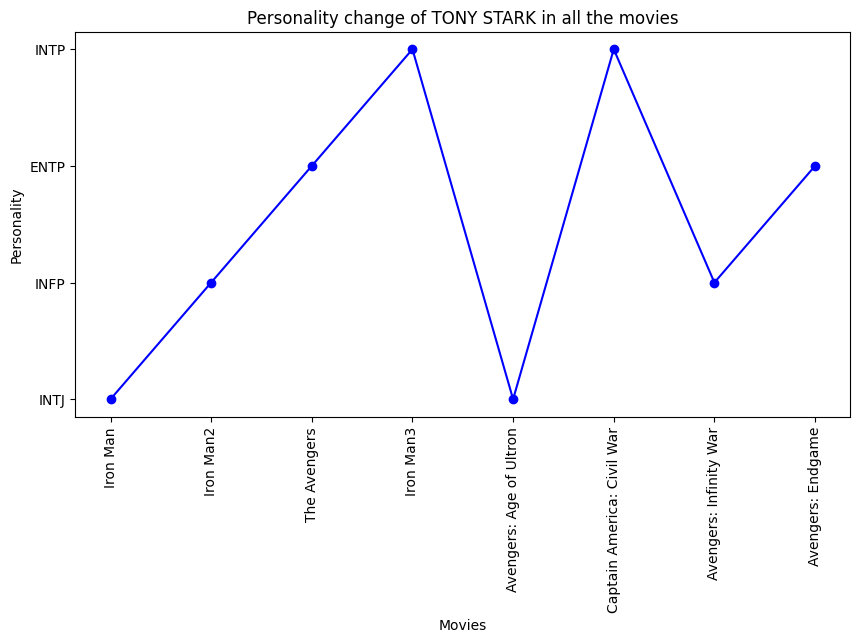

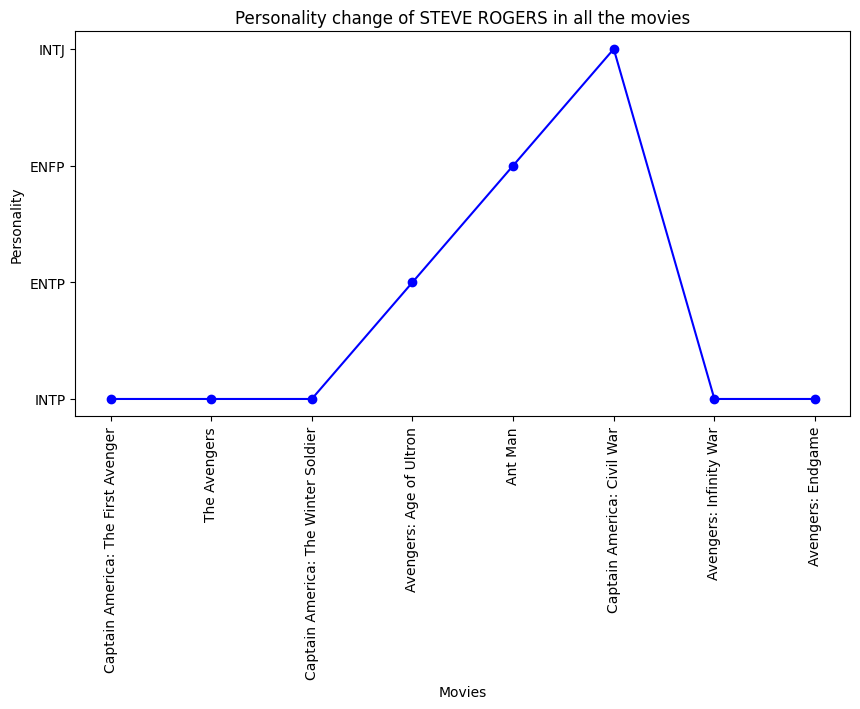

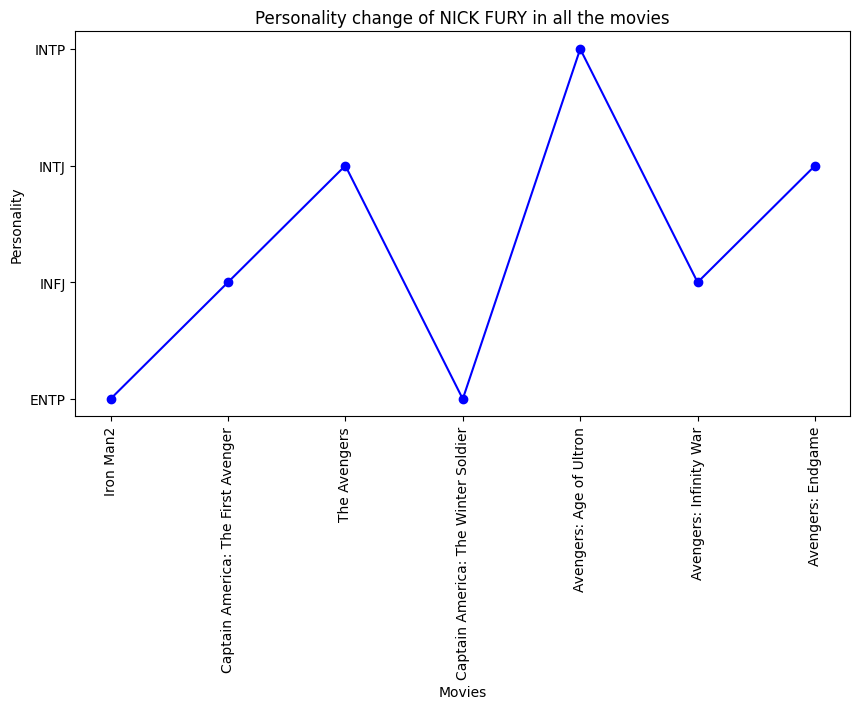

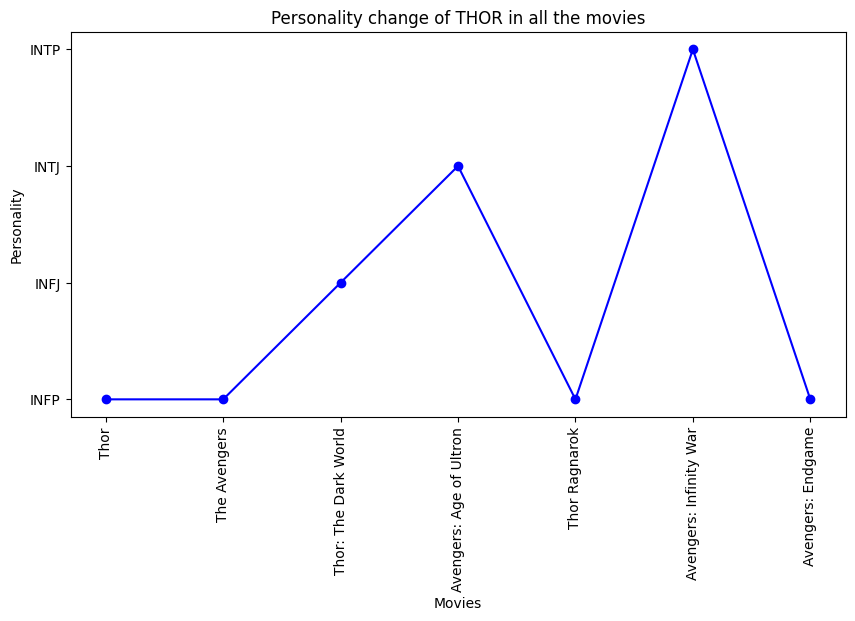

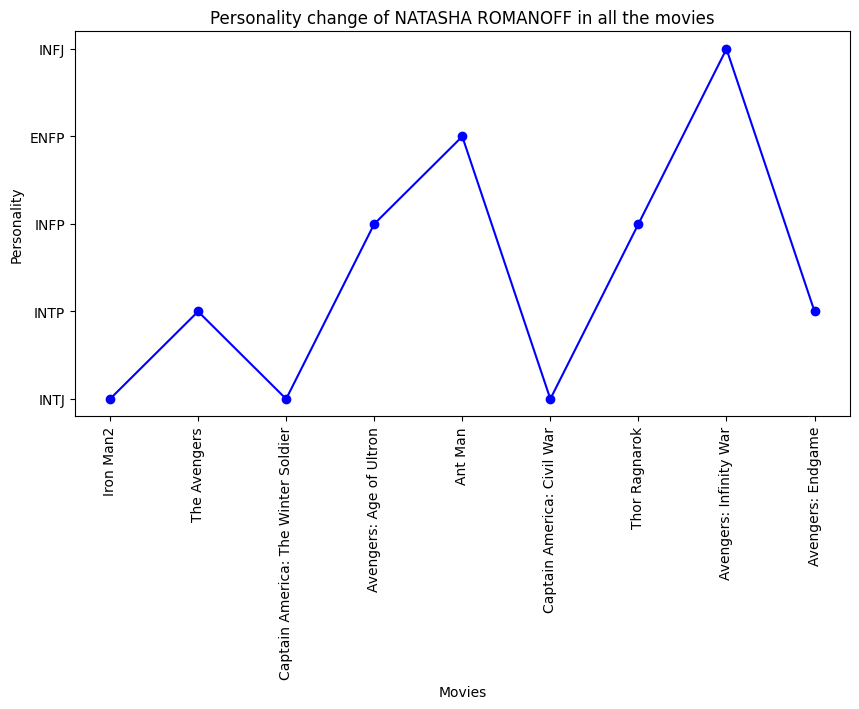

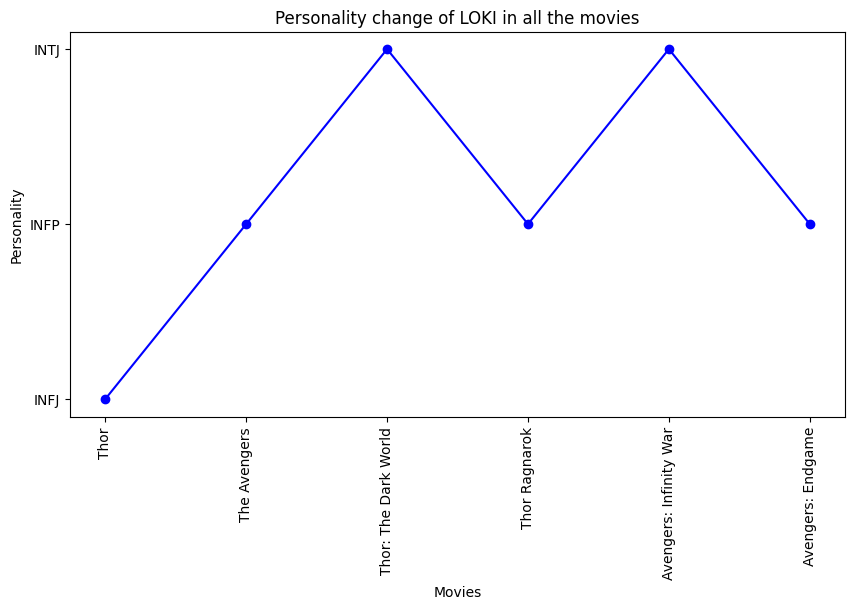

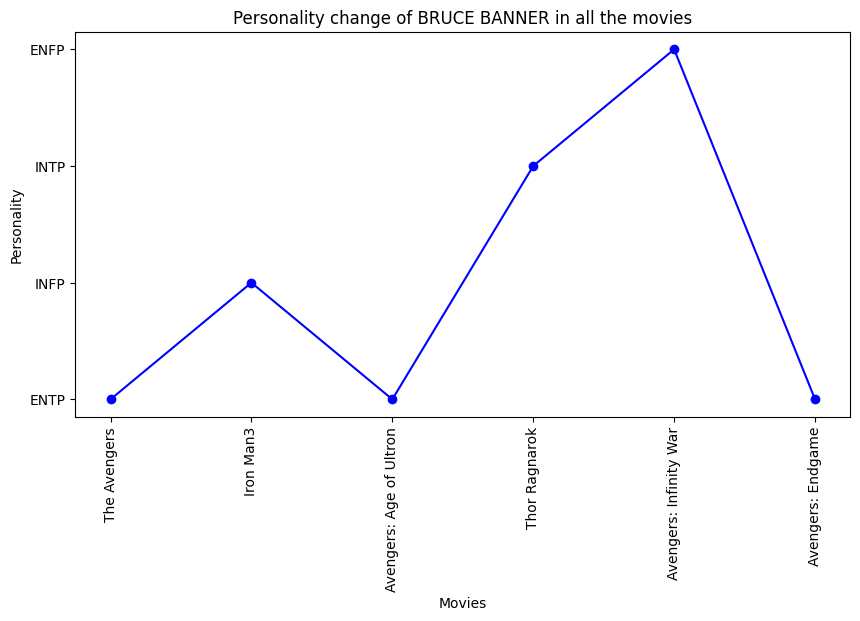

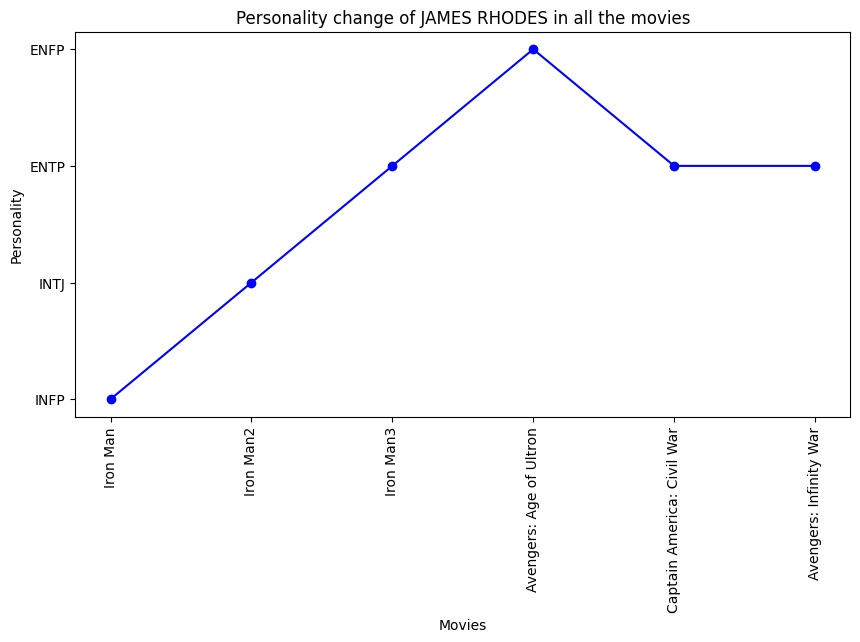

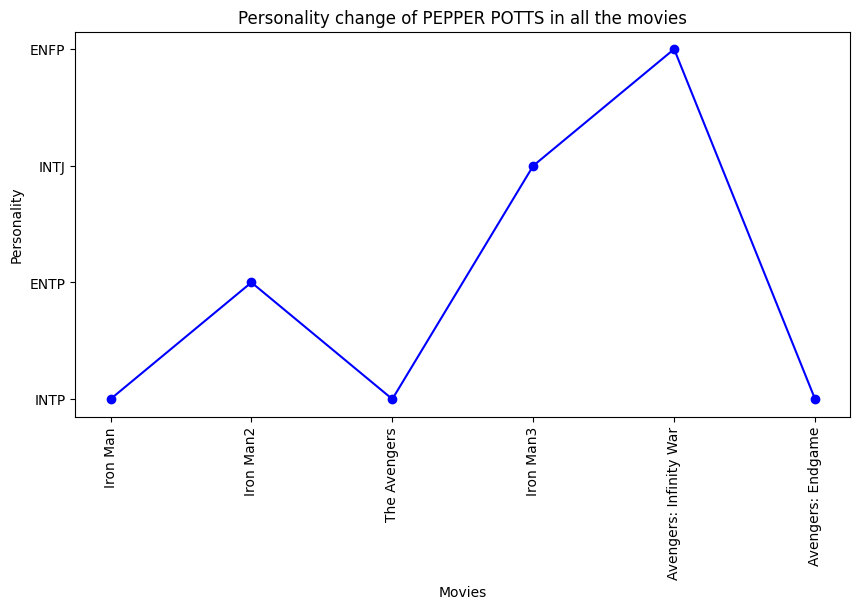

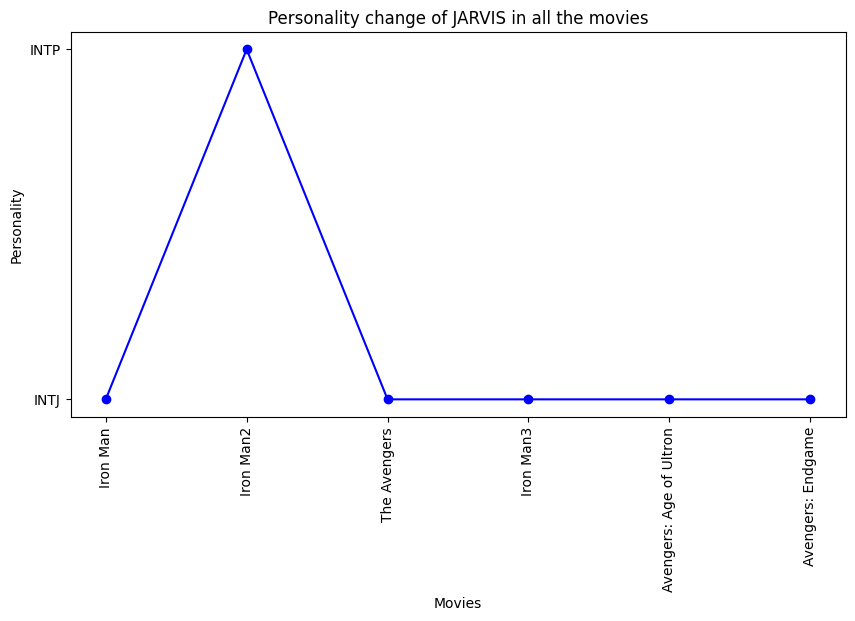

In [102]:
plot_personality('TONY STARK')
plot_personality('STEVE ROGERS')
plot_personality('NICK FURY')
plot_personality('THOR')
plot_personality('NATASHA ROMANOFF')
plot_personality('LOKI')
plot_personality('BRUCE BANNER')
plot_personality('JAMES RHODES')
plot_personality('PEPPER POTTS')
plot_personality('JARVIS')